#Assignment 2, MECH 501#
David Brenken 260786037

Task 1. The problem, related to mechanical engineering, is: can a CNN classify sounds? And how does manipulation (in particular, the short-term fourier transform) of the time-series acoustic data affect classification? This is useful in many different contexts, including robotics and automation, where an agent could make different decisions based on the sounds it hears.


Task 2. The dataset which is chosen comes from [here](https://project.inria.fr/desed/). It is a dataset of 10 different common household sounds. The sounds are: Alarm/bell/ringing, Blender, Cat, Dog, Dishes, Electric shaver/toothbrush, Frying, Running water, Speech, Vacuum cleaner.

Initially, this project was to use the dataset built for robotics found [here](https://dhiraj100892.github.io/swoosh/). However, this dataset was hosted on dropbox and dropbox auto-disables links which have had many accesses, so I was unable to download this dataset. I sent emails to the authors of the papers, and received no response, so I switched to the most similar dataset I could find.

Task 3. Convolutional neural networks, as discussed in class, are frequently used to analyze time series and frequency domain data. I will be using a CNN to attempt to classify sounds in this dataset.


NOTE: an important note to the grader. All of my code and related files are available [here](https://github.com/dbrenken-code/MECH501_asgn2), on my github. I cannot upload the dataset to mycourses, as it is approximately 5 gigabytes. Additionally, to grade this project ONLY cells marked with #TOGRADE need to be run. These will pull figures and other data from the directory. Replicating the results should be easy, as all model parameters (along with the model itself) are serialized under the "Models" directory. 

In [1]:
#MANDATORY
#PYTHON VERSION 3.10 THIS IS IMPORTANT, NEWER VERSIONS WILL NOT WORK

import os
from matplotlib import pyplot as plt
import tensorflow as tf         #2.10 THIS IS IMPORTANT, NEWER VERSIONS WILL NOT WORK
#import tensorflow_io as tfio
import numpy as np
import pandas as pd
from scipy.io import wavfile
import scipy.signal as scsig 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pygame
import time
from tqdm import tqdm
from pathlib import Path


pygame 2.5.2 (SDL 2.28.3, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


A function definition for listening to .wav files and debugging:

In [2]:
#MANDATORY
def play_wav(file_path):
    pygame.mixer.init()
    pygame.mixer.music.load(file_path)
    pygame.mixer.music.play()

    # Wait for the sound to finish playing
    while pygame.mixer.music.get_busy():
        pygame.time.Clock().tick(10)

    pygame.mixer.quit()

In [3]:
def create_directory(directory_path):
    # Check if the directory exists
    if not os.path.exists(directory_path):
        # Create the directory if it doesn't exist
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

The plan to classify this data will be to use a CNN, as this was the original goal of the project. I will be performing spectral analysis of the time-domain signal to encode frequency information which might otherwise be lost by a NN. Therefore, the spectrogram (a 2-D input) will act as the input to my CNN. For consistency in spectrogram dimensions, we must resample the audio at a consistent rate, so I have defined a function to do that below

In [4]:
# MANDATORY
def resample_audio(input_file, target_sample_rate, target_duration=10.0):
    # Read the input .wav file
    sample_rate, audio = wavfile.read(input_file)
    
    # Convert to mono if stereo
    if len(audio.shape) > 1 and audio.shape[1] == 2:
        audio = np.mean(audio, axis=1)

    # Determine the current number of samples
    num_samples = len(audio)

    # Calculate the new number of samples after resampling
    new_num_samples = int(num_samples * target_sample_rate / sample_rate)

    # Resample the audio
    resampled_audio = scsig.resample(audio, new_num_samples)

    # Ensure the resampled array has the desired duration
    target_samples = int(target_sample_rate * target_duration)
    
    if len(resampled_audio) < target_samples:
        # Pad with zeros if the length is less
        resampled_audio = np.pad(resampled_audio, (0, target_samples - len(resampled_audio)), 'constant')
    elif len(resampled_audio) > target_samples:
        # Truncate if the length is more
        resampled_audio = resampled_audio[:target_samples]

    return resampled_audio

The hyperparameters of this function "compute_spectrogram" will eventually be tuned. I particularly want to examine the effect of changing the window function on CNN accuracy. As sound is made up of waves, spectral data is subject to the uncertainty principle. The more resolution one attains in the time domain, the less is available in the frequency domain, and vice versa. The window function, as well as window length and overlap, offer a way to control resolution in the time or frequency domain.

In [5]:
#MANDATORY
def compute_spectrogram(audio, sample_rate, window_type='hann', nperseg=256, noverlap=32):
    #ensure audio is 1-D
    audio = tf.reshape(audio, [-1])
    # Ensure audio is a NumPy array
    audio = np.asarray(audio)

    # Define a custom window function
    window = scsig.get_window(window_type, nperseg)

    # Compute the spectrogram using the custom window
    _, _, Sxx = scsig.spectrogram(audio, fs=sample_rate, window=window, nperseg=nperseg, noverlap=noverlap)

    # Convert to decibels
    
    # Add a small constant to avoid taking the log of zero
    eps = 1e-10
    Sxx_db = 10 * np.log10(Sxx + eps)
    

    return Sxx_db

It is common practice to normalize spectrograms

In [6]:
#MANDATORY
def normalize_spectogram(spectrogram):
    #this function normalizes the spectogram 
    # Reshape the spectrogram to be a 2D array
    reshaped_spectrogram = np.reshape(spectrogram, (spectrogram.shape[0] * spectrogram.shape[1], 1))

    # Use StandardScaler to normalize
    scaler = StandardScaler()
    normalized_spectrogram = scaler.fit_transform(reshaped_spectrogram)

    # Reshape back to the original shape
    normalized_spectrogram = np.reshape(normalized_spectrogram, spectrogram.shape)

    return normalized_spectrogram

In [7]:
#MANDATORY
def save_spectrogram_to_file(spectrogram, filename):
    """Serialize and save a spectrogram to a file."""
    np.save(filename, spectrogram)

def load_spectrogram_from_file(filename):
    """Load a spectrogram from a file."""
    return np.load(filename)


The first step is to re-serialize all of the data as spectrograms. This will allow the CNN training process to be faster, as for each step, the program will not have to compute short-term fourier transforms or audio resampling.

In [8]:
#MANDATORY
def map_data_as_spectro(sample_rate, window_type, nperseg, noverlap):
    input_dir = ".\\CNN_data\\audio"
    output_dir = ".\\CNN_data\\spectrograms"

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if the output directory is empty
    if not os.listdir(output_dir):
        # Loop through the files in the input directory
        for filename in tqdm(os.listdir(input_dir), desc="Processing files"):
            file_path_in = os.path.join(input_dir, filename)
            
            # Replace .wav extension with .npy
            filename_base = os.path.splitext(filename)[0]
            file_path_out = os.path.join(output_dir, f"{filename_base}.npy")

            # Read and resample the audio
            audio = resample_audio(file_path_in, sample_rate)

            try:
                # Compute and normalize the spectrogram
                spectrogram = compute_spectrogram(audio, sample_rate, window_type=window_type, nperseg=nperseg, noverlap=noverlap)
                spectrogram = normalize_spectogram(spectrogram)
            except ValueError as e:
                print(f"Error processing file '{filename}': {e}")
                continue

            # Save the spectrogram as a .npy file
            save_spectrogram_to_file(spectrogram, file_path_out)
    else:
        print(f"Output directory '{output_dir}' is not empty. Files not processed.")



The below code sets the hyperparams including the resample rate, nperseg, noverlap, and the window type. The function call writes the spectrograms as .npy files to the directory .\\CNN_data\\spectrograms

In [9]:
#TRAIN
# NOTE that the windowtype, nperseg, and noverlap are all hyperparams which change the resolution in the time/frequency domain depending on their values. I will be using default values to start
resample_rate = 16000
num_per_seg = 256
num_overlap = 32
window_type = 'hann'

map_data_as_spectro(resample_rate, window_type=window_type, nperseg=num_per_seg, noverlap=num_overlap)

Output directory '.\CNN_data\spectrograms' is not empty. Files not processed.


Loading the labels from the tsv file containing labels

In [10]:
# Load labels from TSV file
labels_path = ".\\CNN_data\\weak_labels.tsv"
labels_df = pd.read_csv(labels_path, delimiter='\t')

file_column = 'filename'
label_column = 'event_label'

In [11]:
data_dir = ".\\CNN_data\\spectrograms"
file_paths = [os.path.join(data_dir, file.replace('.wav', '.npy')) for file in labels_df[file_column]]

Re-defining the labels as a 10-element binary vector, where each element represents the presence/absence of an element inside the audio file.

In [12]:
def create_labels(label_str):
    # ORDER: 
    # [0] ALARM_BELL_RINGING 
    # [1] BLENDER
    # [2] CAT 
    # [3] DOG 
    # [4] DISHES
    # [5] ELECTRIC_SHAVER_TOOTHBRUSH 
    # [6] FRYING 
    # [7] RUNNING_WATER 
    # [8] SPEECH
    # [9] VACUUM_CLEANER
    label_mapping = {
        'alarm_bell_ringing': 0,
        'blender': 1,
        'cat': 2,
        'dog': 3,
        'dishes': 4,
        'electric_shaver_toothbrush': 5,
        'frying': 6,
        'running_water': 7,
        'speech': 8,
        'vacuum_cleaner': 9
    }

    # Initialize a vector of length 10 with zeros
    label_vector = np.zeros(10)

    # Split the label_str into individual labels
    
    labels = label_str.split(',')
    

    # Map each label to its corresponding index in the vector
    for label in labels:
        label = label.strip().lower()  # Remove leading/trailing whitespaces and convert to lowercase
        if label in label_mapping:
            label_index = label_mapping[label]
            label_vector[label_index] = 1

    return label_vector.reshape(10)
    

In [13]:
labels = [create_labels(x) for x in labels_df[label_column]]

Creating a dataframe

In [14]:
data = pd.DataFrame({file_column: file_paths, label_column: labels})

In [15]:
def load_data_from_file(filename_tensor):
    # Use tf.py_function to call the load_data_from_file function
    return tf.py_function(func=lambda filename: np.load(filename.numpy().decode('utf-8')), inp=[filename_tensor], Tout=tf.float32)

def load_and_preprocess(file_path, label):
    # Load and preprocess your spectrogram images (adjust as needed)
    spectrogram = load_data_from_file(file_path)
    return spectrogram, label

def add_channel_dimension(x, y):
    x = tf.expand_dims(x, axis=-1)
    return x, y



Setting a random seed which should allow for reproduceablility of data generation. Also, the below data splits the data into training, validation, and testing data:  
Training: 65.6%  
Validation: 16.4 %  
Test: 18 %  

(Note this split was later changed to ~70%, 10%, 15%)  
The hyperparameters are set here  

In [16]:
seed = 42
model_name = "model3"

np.random.seed(seed)
seed_1 = seed               #42, 612, 201
tf.random.set_seed(seed_1)  #currently the seed affects training/val/test data split as well as weights, I do not necessarily want this dependency
kernel_size = 3
max_pool_size = 2
num_conv_filters = 32
num_dense_layers = 4
dense_layer_size = 64
num_epochs = 8

train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=seed)

Creating the tensorflow datasets, and pre-shuffling them to remove structural biases

In [17]:
# Create TensorFlow datasets
batch_size = 16
labels_array_train = np.asarray(train_data[label_column].tolist(), dtype=np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[file_column], labels_array_train))
train_dataset = train_dataset.map(load_and_preprocess)
train_dataset = train_dataset.map(add_channel_dimension)
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [18]:
labels_array_val = np.asarray(val_data[label_column].tolist(), dtype=np.float32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data[file_column], labels_array_val))
val_dataset = val_dataset.map(load_and_preprocess)
val_dataset = val_dataset.map(add_channel_dimension)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [19]:
labels_array_test = np.asarray(test_data[label_column].tolist(), dtype=np.float32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data[file_column], labels_array_test))
test_dataset = test_dataset.map(load_and_preprocess)
test_dataset = test_dataset.map(add_channel_dimension)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [21]:
#getting height & width from an arbitrary spectrogram, all spectrograms should be the SAME SIZE
file_name = "Y0BgI0XxW0kE_340.000_350.000"
path = os.path.join(".\\CNN_data\\spectrograms", (file_name + ".npy"))
spectrogram_1 = load_spectrogram_from_file(path)
height, width = spectrogram_1.shape





In [22]:
# Defining model
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(num_conv_filters, (kernel_size, kernel_size), activation='relu', input_shape=(height, width, 1)),
    tf.keras.layers.MaxPooling2D((max_pool_size, max_pool_size)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_layer_size),
    tf.keras.layers.Dense(dense_layer_size),
    tf.keras.layers.Dense(dense_layer_size, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs
])


In [23]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision()])


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 712, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 356, 32)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 717696)            0         
                                                                 
 dense (Dense)               (None, 64)                45932608  
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                        

Training the model:

In [25]:
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset, batch_size = 16)

Epoch 1/8
137/137 [==============================] - 9s 38ms/step - loss: 5.6902 - binary_accuracy: 0.8169 - precision: 0.3148 - val_loss: 0.6074 - val_binary_accuracy: 0.8525 - val_precision: 0.5439
Epoch 2/8
137/137 [==============================] - 8s 35ms/step - loss: 0.3593 - binary_accuracy: 0.8761 - precision: 0.6794 - val_loss: 0.4553 - val_binary_accuracy: 0.8475 - val_precision: 0.5282
Epoch 3/8
137/137 [==============================] - 8s 35ms/step - loss: 0.1916 - binary_accuracy: 0.9117 - precision: 0.9019 - val_loss: 0.5456 - val_binary_accuracy: 0.8327 - val_precision: 0.4009
Epoch 4/8
137/137 [==============================] - 8s 35ms/step - loss: 0.1228 - binary_accuracy: 0.9286 - precision: 0.9610 - val_loss: 0.4613 - val_binary_accuracy: 0.8571 - val_precision: 0.5759
Epoch 5/8
137/137 [==============================] - 8s 35ms/step - loss: 0.0800 - binary_accuracy: 0.9379 - precision: 0.9794 - val_loss: 0.5112 - val_binary_accuracy: 0.8623 - val_precision: 0.6172


In [26]:
final_metrics = model.evaluate(test_dataset)
create_directory(os.path.join(".\\Models", model_name))

29/29 [==============================] - 1s 29ms/step - loss: 0.8469 - binary_accuracy: 0.8483 - precision: 0.4888
Directory '.\Models\model2.4' created.


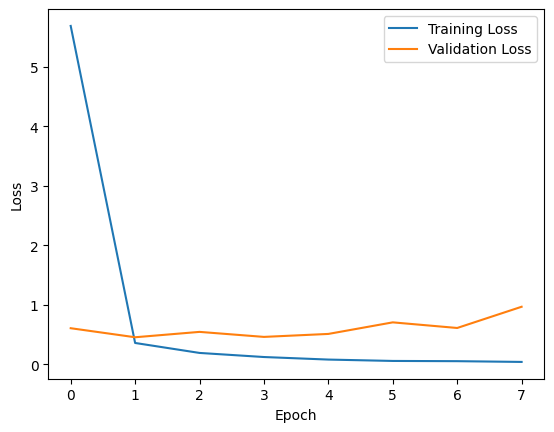

In [27]:
# Plot loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f".\\Models\\{model_name}\\loss.png")
plt.show()


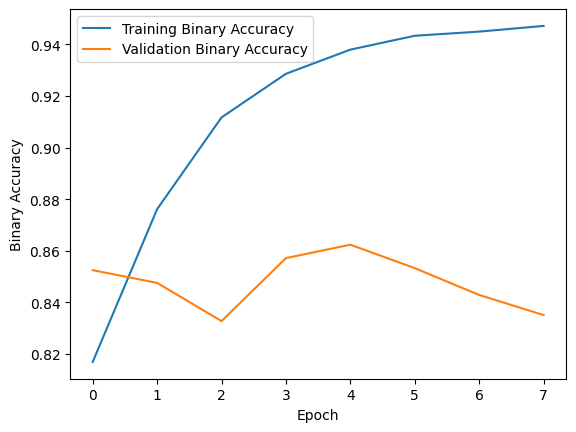

In [28]:
plt.plot(history.history['binary_accuracy'], label='Training Binary Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.savefig(f".\\Models\\{model_name}\\accuracy.png")
plt.show()

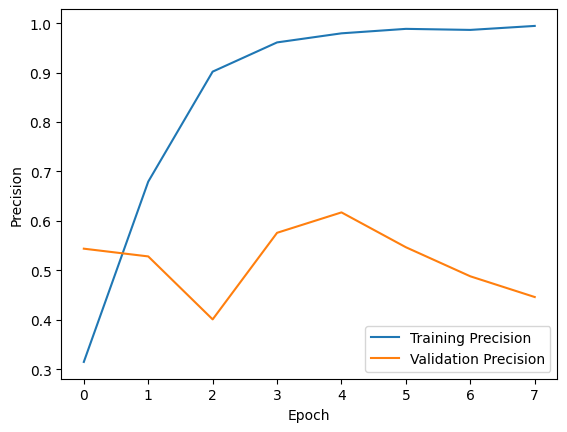

In [29]:

plt.plot(history.history['precision'], label='Training Precision')    #Note when re-running cell by cell, the precision_X increments by 1
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.savefig(f".\\Models\\{model_name}\\Precision.png")
plt.show()


In [30]:
test_loss = final_metrics[0]
test_binary_accuracy = final_metrics[1]
test_precision = final_metrics[2]

generalization_error = {
    'Test Loss': test_loss,
    'Test Binary Accuracy': test_binary_accuracy,
    'Test Precision': test_precision
}

print("Generalization Error:")
for metric, value in generalization_error.items():
    print(f"{metric}: {value}")

Generalization Error:
Test Loss: 0.8469266295433044
Test Binary Accuracy: 0.8483443856239319
Test Precision: 0.4887780547142029


In [31]:
model.save(os.path.join(".\\Models", model_name, (model_name + ".h5")))

hyperparams = [resample_rate, num_per_seg, num_overlap, window_type, kernel_size, max_pool_size, num_conv_filters, num_dense_layers, dense_layer_size, num_epochs, seed_1]

import csv

def write_hyperparameters_to_csv(file_path, hyper_params, generalization_error):
    """
    Write hyperparameters and their corresponding values to a CSV file.

    Parameters:
    - file_path (str): The path to the CSV file.
    - hyper_params (list): List of hyperparameter values.
    """
    # Open the CSV file in write mode
    with open(file_path, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)

        # Write data rows
        writer.writerow(['Resample Rate', hyper_params[0]])
        writer.writerow(['Num Per Seg', hyper_params[1]])
        writer.writerow(['Num Overlap', hyper_params[2]])
        writer.writerow(['Window Type', hyper_params[3]])
        writer.writerow(['Kernel Size', hyper_params[4]])
        writer.writerow(['Max Pool Size', hyper_params[5]])
        writer.writerow(['Num Conv Filters', hyper_params[6]])
        writer.writerow(['Num Dense Layers', hyper_params[7]])
        writer.writerow(['Dense Layer Size', hyper_params[8]])
        writer.writerow(['Num Epochs', hyper_params[9]])
        writer.writerow(['Seed', hyper_params[10]])
        writer.writerow(["Generalization Error:"])
        for metric, value in generalization_error.items():
            writer.writerow([f"{metric}: {value}"])
                
write_hyperparameters_to_csv(os.path.join(".\\Models", model_name, (model_name + ".csv")), hyper_params=hyperparams, generalization_error=generalization_error)

#### CONCLUSION

The initial model is here (model1):

| Layer (type) | Output Shape | Param # |
|-----------|-----------|-----------|
| conv2d | (None, 127, 712, 32) | 320 |
| max_pooling2d | (None, 63, 356, 32) | 0 |
| flatten | (None, 717696) | 0 |
| dense (Dense) | (None, 64) | 45932608 |
| dense | (None, 10) | 650 |

This model was set semi-arbitrarily. The logic behind setting the layers was as follows: the conv2d was required for satisfying the definition of a concolutional neural network. The max pooling layer helps to reduce the locality of information from the spectrogram, i.e. the NN will look for patterns with less regard to what frequency/time they appear at. Max pooling has previously been shown to improve image classification tasks [1].  
The flatten layer is to transform the neural network from 2 dimensions to one dimension, as the output vector is 10x1. The dense layer is a classical fully connected layer, and to increase capacity I will add more layers of this exact type. The final layer transforms the required dimension to 10x1.  





[1] J. Nagi et al., "Max-pooling convolutional neural networks for vision-based hand gesture recognition," 2011 IEEE International Conference on Signal and Image Processing Applications (ICSIPA), Kuala Lumpur, Malaysia, 2011, pp. 342-347, doi: 10.1109/ICSIPA.2011.6144164.

Models 1-1.6 increase the number of epochs. My methodology was to keep the seed the same, unless a scenario arose where the precision (train, validation, and test) got into a "rut" and was 0 for several of the epochs. This indicates that no correct guesses were made. I posit that this is in part due to the dataset. The downloaded dataset (of which a large proportion of files were missing upon download) only contains around 3000 samples. This does not seem like a large enough number for a 10-class classifier, as if we simply perform a back-of the envelope calculation, this is only roughly 300 examples per category (not including category overlap, where two or more sounds are present in the audio file. Note that there is a LARGE amount of category overlap in this dataset). Due to the small amount of data, it is entirely possible that in the train/test/validation split, the validation or test data contains a large proportion of the label "Cat" for example, while the training data has almost no examples of this.

After model 1.6, I redid the training/test/validation split to have 15 percent test and ~10 percent validation, so that it is more likely to have enough test data. The generalization error graph, shown here: ![Local Image](./Results/test_loss_vs_epochs_1.png)  <br></br>does not provide a clear picture of the loss decreasing over time, reaching a minimum, then reaching an area of overfitting. This variation in the data is likely due to the high nonlinearity of the loss function. To counteract this, I would re-run the code with several different weight initializations and the same number of epochs, to ensure that I had reached the global minimum of the loss function. This is beyond the scoope of this project, however, as I would like to examine other factors besides the number of epochs. 

However, we can examine this phenomenon from <br></br> ![Local Image](./Models/model1.10/loss.png) <br></br> Which shows the training/validation loss over epochs. From this graph, it seems like the optimal number of epochs is approximately between 6-8. Although altering the model further will change what number of epochs is optimal, I will fix this hyperparameter at 8.

For model 2, I added a fully connected layer without an activation function. This increased the capacity of the CNN. Interestingly, after doing this, it seemed like the number of epochs was overfitting according to this plot: <br></br> ![Local image](./Models/model2/loss.png)

Models 2-2.4 add one dense layer each. The test loss decreases, and then increases, with a minimum test loss of ~0.57 at 4 dense layers (2 additional layers compared with model 1). This had a test precision of almost 60%, so I will fix this hyperparameter.

In [32]:
def play_ping_sound():
    # Initialize Pygame mixer
    pygame.mixer.init()

    # Load the ping sound file (replace 'ping_sound.wav' with your actual sound file)
    sound_file = 'ping_sound.wav'
    pygame.mixer.music.load(sound_file)

    # Play the ping sound
    pygame.mixer.music.play()

    # Wait for the sound to finish playing
    while pygame.mixer.music.get_busy():
        time.sleep(1)
        
play_ping_sound()